In [206]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2 #pip install opencv-python
from sklearn.metrics import confusion_matrix, f1_score
from scipy.optimize import minimize
import librosa                    
import librosa.display
from sklearn.preprocessing import normalize

In [220]:
IMG = './data/images_original/'
#IMG = './dataset/'
img_dataset = []
genre_target = []
genres = {}
i = 0
for root, dirs, files in os.walk(IMG):
    for name in files:
        filename = os.path.join(root, name)
        img_dataset.append(filename)
        genre = filename.split('\\')[0].split('/')[-1]
        genre_target.append(genre)
        
        if(genre not in genres):
            genres[genre] = i
            i+=1

In [222]:
print(genres)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


Initial shape: (288, 432)


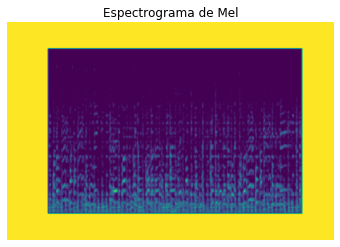

In [223]:
img = cv2.imread(img_dataset[0],0)
print("Initial shape:",img.shape)
plt.imshow(img, interpolation = 'bicubic', cmap='viridis')
plt.title("Espectrograma de Mel")
plt.axis('off')
plt.show()

**Nota:** recortar los bordes externos, al pasarlos como datos no aportan nada

In [226]:
def crop_borders(img,x1=35,x2=252,y1=54,y2=389):
    cropped = img[x1:x2,y1:y2]
    return cropped

Shape: (217, 335)


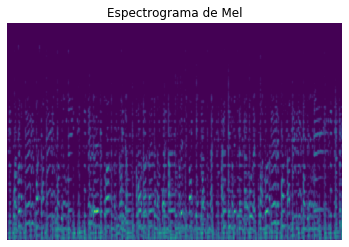

In [289]:
img = cv2.imread(img_dataset[0],0)
img = crop_borders(img)
print("Shape:",img.shape)
plt.imshow(img, interpolation = 'bicubic', cmap='viridis')
plt.title("Espectrograma de Mel")
plt.axis('off')
plt.show()

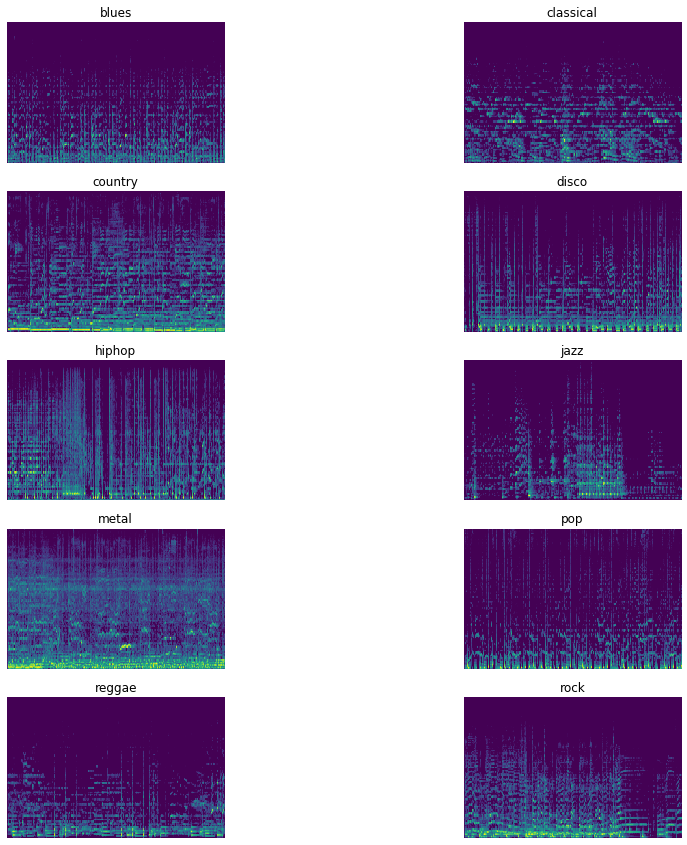

In [300]:
def show_sample_imgs(dataset, cmap='viridis', c=2, r=5):
    np.random.seed(5)
    fig=plt.figure(figsize=(15, 15))
    columns = c
    rows = r
    
    if(c == 2 and r == 5):
        sample = [i * 100 for i in range(len(genres))]
    else:
        sample = np.random.choice(len(img_dataset), columns*rows, 42)
    for i, j in zip(range(1, columns*rows +1),sample):
        fig.add_subplot(rows, columns, i)
        plt.title(genre_target[j])
        plt.imshow(dataset[j], cmap)
        plt.axis('off')
    plt.show()
    

show_sample_imgs(X.reshape([999,217,335]))

In [239]:
def get_y():
    '''Convierte los generos en un array de targets y'''
    y = []
    for genre in genre_target:
        #OneHot encoding?
        n = genres[genre]
        y.append(n)
    return np.array(y)

def get_x(shape=[999,217*335], flag=0):
    x = np.empty(shape, np.uint8)
    for i in range(len(img_dataset)):
        img = cv2.imread(img_dataset[i],flag)
        img = crop_borders(img)
        x[i] = img.ravel()
    return np.array(x)

In [241]:
X = get_x()

In [314]:
y = get_y().reshape(len(y),1)

In [246]:
print(X.shape, y.shape)

(999, 72695) (999, 1)


## Prueba de uso de valores del espectograma

C:\Users\willw\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


KeyboardInterrupt: 

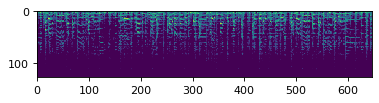

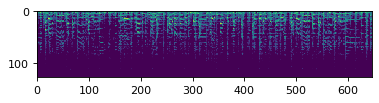

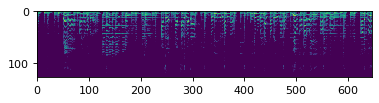

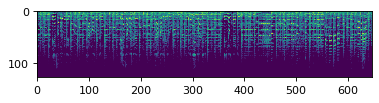

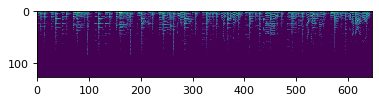

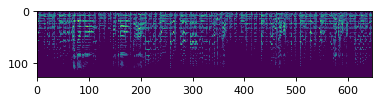

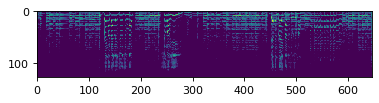

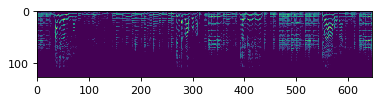

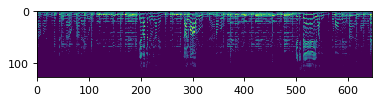

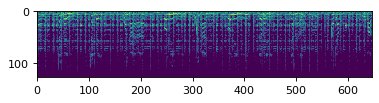

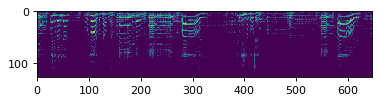

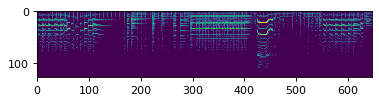

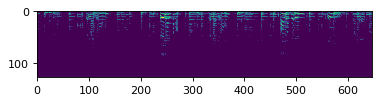

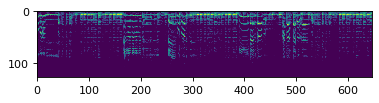

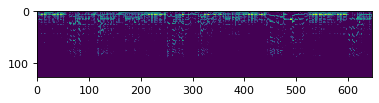

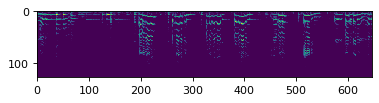

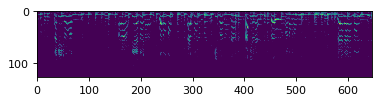

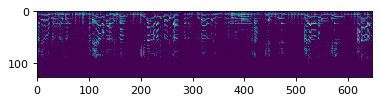

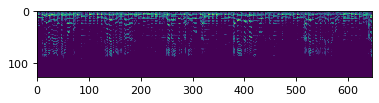

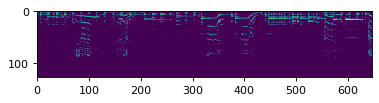

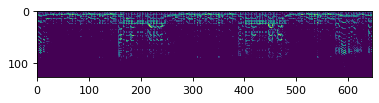

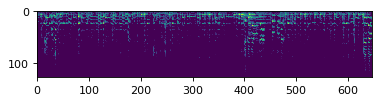

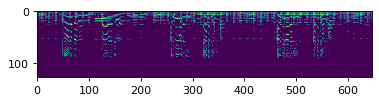

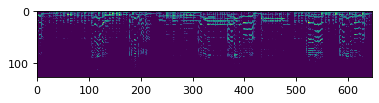

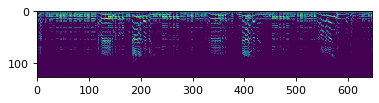

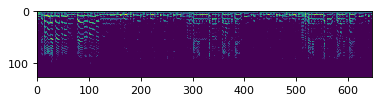

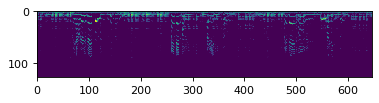

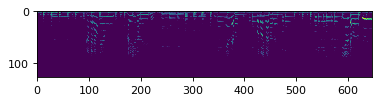

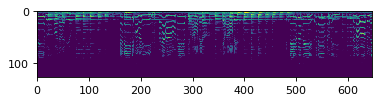

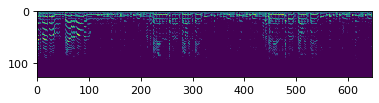

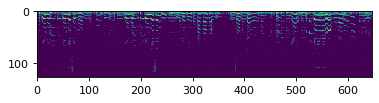

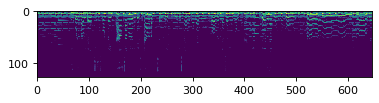

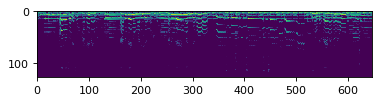

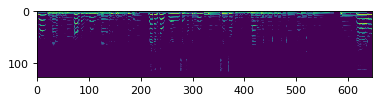

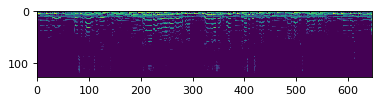

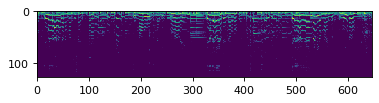

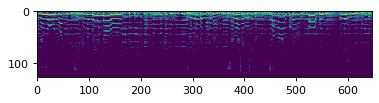

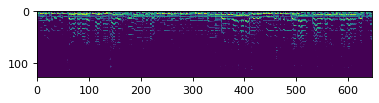

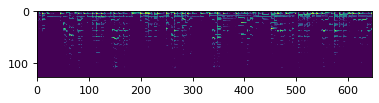

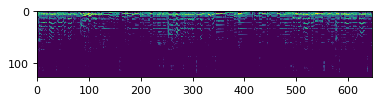

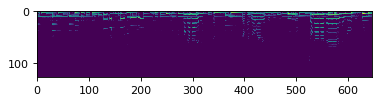

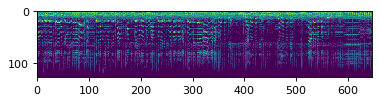

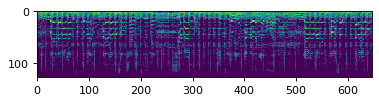

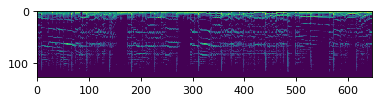

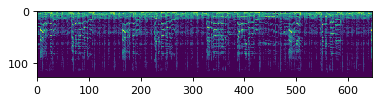

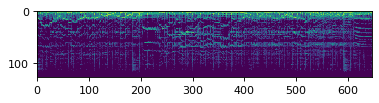

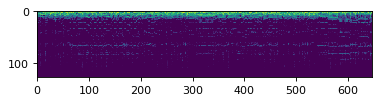

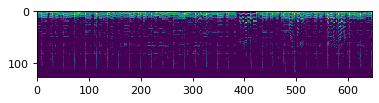

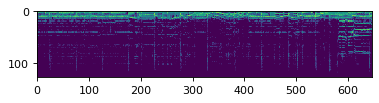

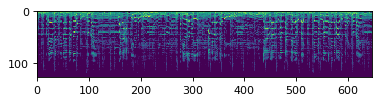

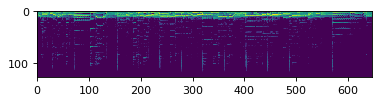

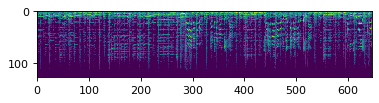

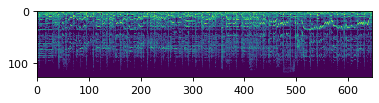

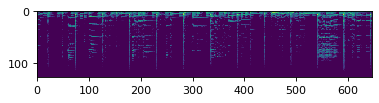

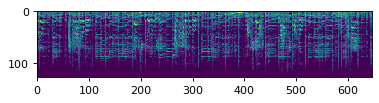

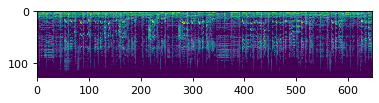

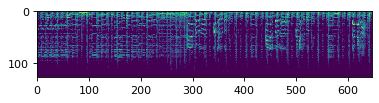

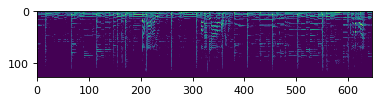

Error in callback <function flush_figures at 0x0000018932A24F78> (for post_execute):


KeyboardInterrupt: 

In [279]:
def mel(file):
    '''devuelve un array con los valores del spectograma de mel de un fichero'''
    n_mels = 128
    hop_length = 1024
    n_fft = 2048

    file_location = file
    y, sr = librosa.load(file_location, duration = 30)
    #song,_ = librosa.effects.trim(y)
    song = y
    S = librosa.feature.melspectrogram(song, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)
    
    #Normalizar esto?
    #S_DB_ravel = S_DB.ravel()
    #normalized = normalize(S_DB_ravel[:,np.newaxis], axis=0, norm='l2').ravel()
    #normalized = np.reshape(normalized, S_DB.shape)
    
    plt.figure(figsize=(432/80, 288/80), dpi=80)
    S_DB[S_DB < -40] = -40
    return S_DB.ravel()

def get_melX(shape):
    MUSIC = './data/genres_original'
    
    x = np.empty([999,shape], np.uint8)
    i = 0
    for root, dirs, files in os.walk(MUSIC):
        for name in files:
            filename = os.path.join(root, name)
            if(filename != "./data/genres_original\jazz\jazz.00054.wav"): #corrupted
                spectrum = mel(filename).ravel()
                if(len(spectrum) < shape):
                    #En caso de que una cancion dure menos de 30s rellenamos con 0s
                    padding = np.zeros(np.abs(len(spectrum)-shape))
                    spectrum = np.append(spectrum,padding)
                x[i] = spectrum
                i += 1
    return x

shape = len(mel("./data/genres_original/blues/blues.00000.wav"))
X_mel = get_melX(shape)

In [ ]:
X_mel.shape

**Entrenamiento con NN**

In [327]:
m = len(y)
input_size = X.shape[1] #72695
num_labels = len(genres) #10

hidden_size = 25
learning_rate = 1

def one_hot(y, m, num_labels):
    '''one hot encoding'''
    y_onehot = np.zeros((m, num_labels))  # 5000 x 10
    for i in range(m):
        y_onehot[i][y[i]] = 1
    return y_onehot

y_onehot = one_hot(y, m, num_labels)

### Funciones de practica de NN

In [370]:
#funcion sigmoide
def sigmoid(z):
    return 1/(1+np.exp(-z))

#derivada de la funcion sigmoide
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), 1-sigmoid(z))

#propagacion hacia delante de la red
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]
    a1 = np.hstack([np.ones([m, 1]), X])
    z2 = np.dot(a1, theta1.T)
    a2 = np.hstack([np.ones([m, 1]), sigmoid(z2)])
    z3 = np.dot(a2, theta2.T)
    h = sigmoid(z3)
    return a1, z2, a2, z3, h

#computa el coste y el gradiente de la red neuronal, propagando hacia atras la red
def backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg = 0):
    #desenredar los parametros pasados como un array en params_rn
    theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)] ,(num_ocultas , (num_entradas + 1)))
    theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):] ,(num_etiquetas, (num_ocultas + 1)))
    m = X.shape[0]
    
    #forward_prop params
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    #calculo del coste
    cost = 0
    
    for i in range(m):
        #primer termino
        primer_termino = np.dot(-y[i,:], np.log(h[i,:]))
        #segundo termino
        segundo_termino = np.dot(1 - y[i,:], np.log(1 - h[i,:]))

        cost += np.sum(primer_termino - segundo_termino)
        
    cost = cost / m
    
    #con regularizacion
    if reg != 0:
        cost += reg/(2*m) * (np.sum(np.power(theta1[:, 1:], 2)) + np.sum(np.power(theta2[:, 1:], 2)))
    
    
    #backpropagation
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    for t in range(m):
        a1t = a1[t, :] # (1, 401)
        a2t = a2[t, :] # (1, 26)
        ht = h[t, :] # (1, 10)
        yt = y[t] # (1, 10)
        d3t = ht - yt # (1, 10)
        d2t = np.dot(theta2.T, d3t) * (a2t * (1 - a2t)) # (1, 26)
        delta1 = delta1 + np.dot(d2t[1:, np.newaxis], a1t[np.newaxis, :])
        delta2 = delta2 + np.dot(d3t[:, np.newaxis], a2t[np.newaxis, :])
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    #con regularizacion
    if reg != 0:
        delta1[:, 1:] = delta1[:, 1:] + (theta1[:, 1:] * reg) / m
        delta2[:, 1:] = delta2[:, 1:] + (theta2[:, 1:] * reg) / m
    
    #gradiente computado de cada capa
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return cost, grad

#devuelve una matriz aleatoria de (L_in, L_out + 1) que se encuentra entre el rango de (-e_ini, e_ini)
def pesosAleatorios(L_in, L_out):
    e_ini = 0.12
    params = np.random.rand(L_in, L_out + 1)
    params = ((e_ini - (-e_ini)) * params) - e_ini #Regularizar entre (-e_ini, e_ini)
    return params


def scores(y, neural_pred, show = True):
    f1 = f1_score(y, neural_pred, average='weighted')
    accuracy = np.mean(neural_pred == y[:])
    print("f1_score:", f1)
    print("accuracy:", accuracy)
    if show:
        plt.figure(figsize = (10,10))
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.xticks(genre_)
        plt.yticks(genre_)
        plt.imshow(confusion_matrix(y, neural_pred), cmap='viridis')
        plt.show()
    return f1, accuracy

In [335]:
def train_nn(X , y, input_size, num_labels, hidden_size, learning_rate):
    y_onehot = one_hot(y, len(y), num_labels)
    
    theta1_rand = pesosAleatorios(hidden_size, X.shape[1])
    theta2_rand = pesosAleatorios(num_labels, hidden_size)

    params = np.concatenate((np.ravel(theta1_rand), np.ravel(theta2_rand)))

    fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size, num_labels, X, y_onehot, learning_rate), 
                    method='TNC', jac=True, options={'maxiter': 10})
    
    theta1_train = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2_train = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

    a1, z2, a2, z3, h = forward_propagate(X, theta1_train, theta2_train)
    neural_pred = h.argmax(axis=1)
    y = get_y()
    f1, accuracy = scores(y, neural_pred, show = True)
    return f1, accuracy, a1, z2, a2, z3, h


C:\Users\willw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score: 0.03200100182520155
accuracy: 0.10009909809709609


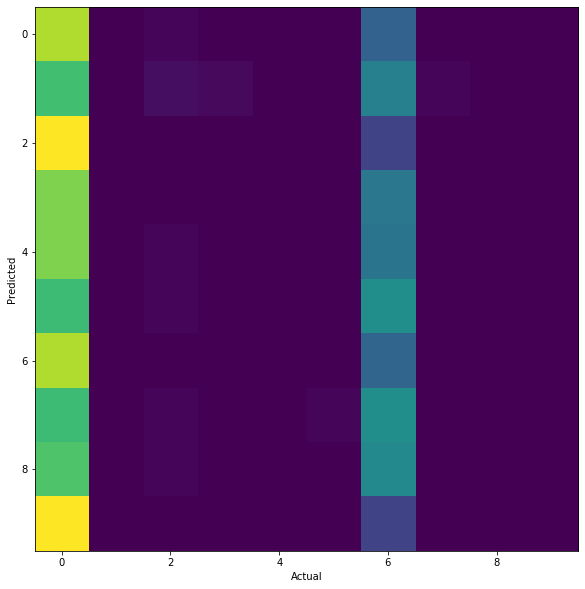

In [360]:
learning_rate = 0.4

f1, accuracy, a1, z2, a2, z3, h = train_nn(X, y, input_size, num_labels, hidden_size, learning_rate)

In [362]:
neural_pred = h.argmax(axis=1)

In [369]:
genre_ = [genre for genre in genres]

genre_

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

f1_score: 0.03200100182520155
accuracy: 0.10009909809709609


C:\Users\willw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ConversionError: Failed to convert value(s) to axis units: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

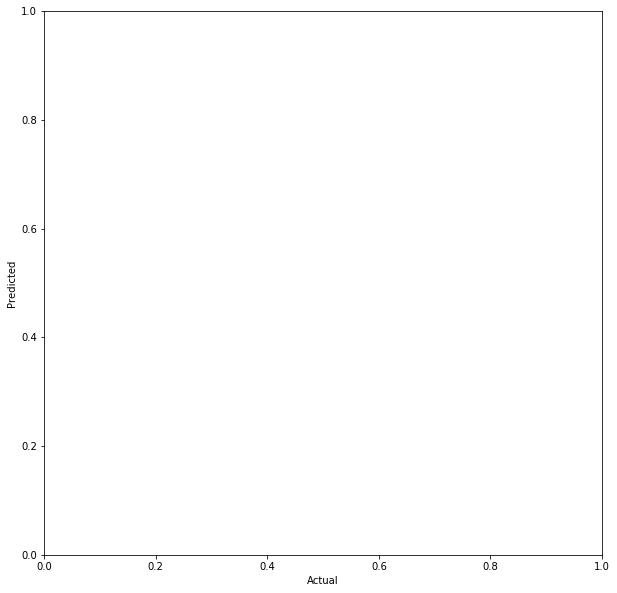

In [371]:
neural_pred = h.argmax(axis=1)
y = get_y()
f1, accuracy = scores(y, neural_pred, show = True)

In [23]:
shape = mel("./data/genres_original\jazz\jazz.00053.wav").shape
X = get_melX(shape)
y = get_y()
m = len(y)
input_size = X.shape[1] #72695
num_labels = len(genres) #10
train_nn(X , y, input_size, num_labels, hidden_size, learning_rate)